In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import joblib
import os
import scipy.io as sio

In [3]:
project = 'kolmogorov'

In [ ]:
# Adjust the path to your project root directory where 'models' folder is located
project_root = os.path.abspath('../../../')  # or the relative path to your root from the notebook folder

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.models.pca import PCA_AE
from src.models.mlp import MLP_AE
from src.models.cnn import CNN_AE

from src.utils import *

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.makedirs(f'{project_root}/src/models/checkpoints/{project}', exist_ok=True)

load_existing_models = True
latent_dim = 50

In [6]:
L1, L2 = 2*np.pi, 2*np.pi
n1, n2 = 64, 64

grid_x = np.linspace(0,L1-L1/n1,n1)
grid_y = np.linspace(0,L2-L2/n2,n2)

grid_x, grid_y = np.meshgrid(grid_x, grid_y)

Kx = np.concatenate([np.arange(0, n1//2), np.arange(-n1//2, 0)]) * (2 * np.pi / L1)
Ky = np.concatenate([np.arange(0, n2//2), np.arange(-n2//2, 0)]) * (2 * np.pi / L2)

kx, ky = np.meshgrid(Kx,Ky)

dt_sim = 0.5
T_sim = 10000
nt = int(T_sim/dt_sim)

In [53]:
u1 = np.load(f'{project_root}/data/{project}/u1.npy') 
u2 = np.load(f'{project_root}/data/{project}/u2.npy')
w = np.load(f'{project_root}/data/{project}/vorticity.npy')
nt, n1, n2 = u1.shape

X, scaler = transform_data_for_AE(u1,u2)
X_flat = X.reshape(X.shape[0], -1)

data = transform_data_for_AE_inverse(X, scaler)

print(f"Data shape: {X.shape}, Flat shape: {X_flat.shape}")

Data shape: (20000, 2, 64, 64), Flat shape: (20000, 8192)


In [8]:
# === Consistent train/val/test split ===
train_idx, val_idx, test_idx = split_indices(nt, split=(0.3, 0.2, 0.5))

X_train = X[train_idx]
X_val = X[val_idx]
X_test = X[test_idx]

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")

X_train_flat = X_flat[train_idx]
X_val_flat = X_flat[val_idx]
X_test_flat = X_flat[test_idx]

print(f"Train flat shape: {X_train_flat.shape}, Val flat shape: {X_val_flat.shape}, Test flat shape: {X_test_flat.shape}")

Train shape: (6000, 2, 64, 64), Val shape: (4000, 2, 64, 64), Test shape: (10000, 2, 64, 64)
Train flat shape: (6000, 8192), Val flat shape: (4000, 8192), Test flat shape: (10000, 8192)


In [9]:
MLP_input_dim = X_train_flat.shape[1]

In [ ]:
pca = PCA_AE.load(f'{project_root}/src/models/checkpoints/{project}/pca_model.pkl')
mlp = MLP_AE(input_dim=MLP_input_dim, latent_dim=latent_dim)
mlp.load_state_dict(torch.load(f'{project_root}/src/models/checkpoints/{project}/mlp_model.pth'))
mlp.to(device)
cnn = CNN_AE(latent_dim=latent_dim)
cnn.load_state_dict(torch.load(f'{project_root}/src/models/checkpoints/{project}/cnn_model.pth'))
cnn.to(device);

In [54]:
# Compute test error for each model

# 1. PCA only (reconstruction from PCA)
X_pca_recon, Z_pca = pca.forward(X_flat)
X_pca_recon = X_pca_recon.reshape(X.shape)
X_pca_recon = transform_data_for_AE_inverse(X_pca_recon, scaler)
pca_test_mse = np.mean((data[test_idx] - X_pca_recon[test_idx]) ** 2)
print(f"PCA test RMSE: {np.sqrt(pca_test_mse):.6f}")

# 2. PCA + MLP Autoencoder
mlp.eval()
with torch.no_grad():
    X_mlp_recon, Z_mlp = mlp(torch.tensor(X_flat, dtype=torch.float32, device=device))
    X_mlp_recon = X_mlp_recon.cpu().numpy()
    X_mlp_recon = X_mlp_recon.reshape(X.shape)
    X_mlp_recon = transform_data_for_AE_inverse(X_mlp_recon, scaler)

    mlp_test_mse = np.mean((data[test_idx] - X_mlp_recon[test_idx]) ** 2)
print(f"MLP AE test RMSE: {np.sqrt(mlp_test_mse):.6f}")

# 3. CNN Autoencoder (batched to avoid CUDA OOM)
cnn.eval()
batch_size = 16  
n_samples = X.shape[0]
X_cnn_recon = []
with torch.no_grad():
    for i in range(0, n_samples, batch_size):
        batch = X[i:i+batch_size]
        batch_tensor = torch.tensor(batch, dtype=torch.float32, device=device)
        recon_batch, _ = cnn(batch_tensor)
        X_cnn_recon.append(recon_batch.cpu().numpy())
X_cnn_recon = np.concatenate(X_cnn_recon, axis=0)
X_cnn_recon = transform_data_for_AE_inverse(X_cnn_recon, scaler)
cnn_test_mse = np.mean((data[test_idx] - X_cnn_recon[test_idx]) ** 2)
print(f"CNN AE test RMSE: {np.sqrt(cnn_test_mse):.6f}")


PCA test RMSE: 0.141217
MLP AE test RMSE: 0.131841
CNN AE test RMSE: 0.069193


In [49]:
# Calculate vorticity from predictions of each model

# 1. PCA
u1_pca = X_pca_recon[:, 0].reshape(-1, n1, n2)
u2_pca = X_pca_recon[:, 1].reshape(-1, n1, n2)
w_pca = vort(u1_pca, u2_pca, kx, ky)

# 2. MLP AE
u1_mlp = X_mlp_recon[:, 0].reshape(-1, n1, n2)
u2_mlp = X_mlp_recon[:, 1].reshape(-1, n1, n2)
w_mlp = vort(u1_mlp, u2_mlp, kx, ky)

# 3. CNN AE
u1_cnn = X_cnn_recon[:, 0].reshape(-1, n1, n2)
u2_cnn = X_cnn_recon[:, 1].reshape(-1, n1, n2)
w_cnn = vort(u1_cnn, u2_cnn, kx, ky)

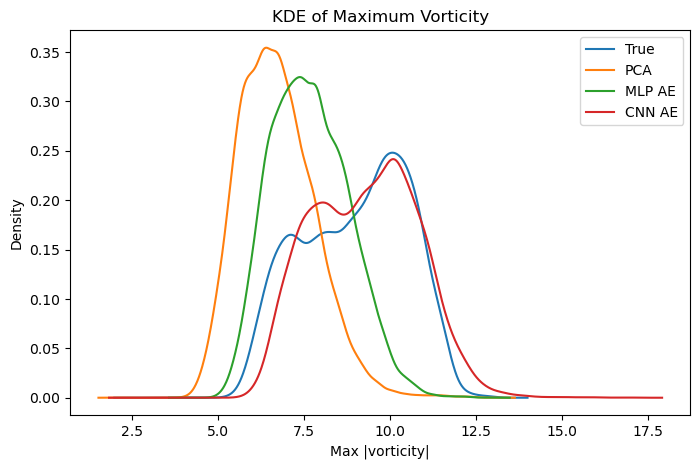

In [52]:
# Compute maximum vorticity for each model and the true data
max_w_true = np.max(np.abs(w), axis=(1,2))
max_w_pca = np.max(np.abs(w_pca), axis=(1,2))
max_w_mlp = np.max(np.abs(w_mlp), axis=(1,2))
max_w_cnn = np.max(np.abs(w_cnn), axis=(1,2))

plt.figure(figsize=(8, 5))
for max_w, label in [
    (max_w_true, 'True'),
    (max_w_pca, 'PCA'),
    (max_w_mlp, 'MLP AE'),
    (max_w_cnn, 'CNN AE')
]:
    kde_x, kde_y = custom_KDE(max_w).evaluate()
    plt.plot(kde_x, kde_y, label=label)
plt.xlabel('Max |vorticity|')
plt.ylabel('Density')
plt.legend()
plt.title('KDE of Maximum Vorticity')
plt.show()
